In [26]:
import os
import pandas as pd
import glob

# import seaborn as sns
# import ast
import re
import sys

import cv2

import numpy as np
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch import optim
import torchvision
from torchvision import transforms
import torchvision.models as models
import torchvision.transforms as T
import torchvision.transforms.functional as TF

from tqdm import tqdm

import matplotlib.pyplot as plt
%matplotlib inline

yolo_path = "../third/yolov7_custom"
sys.path.append(yolo_path)


device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [2]:
mask_model_ver="132508"
IMAGE_SIZE=640

DATA_DIR = "/root/autodl-tmp/cervical_spine/"
IMAGES_DIR = os.path.join(DATA_DIR, 'train_axial_images_jpeg95_croped_132508')
MASK_DIR = os.path.join(DATA_DIR, 'segmentation_axial_results_132508')

# weights = "/root/cervical_spine/third/yolov7_custom/runs/train/yolov7-custom9/weights/last.pt"
# weights = "/root/autodl-tmp/cervical_spine/checkpoint/yolov7-A100-best.pt"

In [3]:
train_df = pd.read_csv(os.path.join(DATA_DIR, 'train.csv')).set_index('StudyInstanceUID')
train_df.head()

,patient_overall,C1,C2,C3,C4,C5,C6,C7
StudyInstanceUID,,,,,,,,
1.2.826.0.1.3680043.6200,1,1,1,0,0,0,0,0
1.2.826.0.1.3680043.27262,1,0,1,0,0,0,0,0
1.2.826.0.1.3680043.21561,1,0,1,0,0,0,0,0
1.2.826.0.1.3680043.12351,0,0,0,0,0,0,0,0
1.2.826.0.1.3680043.1363,1,0,0,0,0,1,0,0


In [64]:
total_boundary_df = pd.read_csv(os.path.join(DATA_DIR, f'infered_boundary_{mask_model_ver}_2.csv'))
total_boundary_df['UID_Slice'] = total_boundary_df['StudyInstanceUID'] + '.' + total_boundary_df['Slice'].astype('string')
total_boundary_df = total_boundary_df.set_index('UID_Slice').astype({'Slice': int})
print(len(total_boundary_df.StudyInstanceUID.unique()))
print(len(total_boundary_df))
total_boundary_df.head()

2012
708779


,StudyInstanceUID,Slice,Start,pixel_spacing,xmin,ymin,xmax,ymax
UID_Slice,,,,,,,,
1.2.826.0.1.3680043.10001.0,1.2.826.0.1.3680043.10001,0,0,0.253906,0.0,0.0,512.0,512.0
1.2.826.0.1.3680043.10001.1,1.2.826.0.1.3680043.10001,1,0,0.253906,0.0,0.0,512.0,512.0
1.2.826.0.1.3680043.10001.2,1.2.826.0.1.3680043.10001,2,0,0.253906,0.0,0.0,512.0,512.0
1.2.826.0.1.3680043.10001.3,1.2.826.0.1.3680043.10001,3,0,0.253906,0.0,0.0,512.0,512.0
1.2.826.0.1.3680043.10001.4,1.2.826.0.1.3680043.10001,4,0,0.253906,0.0,0.0,512.0,512.0


In [5]:
from models.experimental import attempt_load

In [6]:
# model = attempt_load(weights, map_location=device)
# model = model.eval()

In [7]:

test_slices = glob.glob(f'{IMAGES_DIR}/1.2.826.0.1.3680043.219*/*')
test_slices = [re.findall(f'{IMAGES_DIR}/(.*)/(.*).jpeg', s)[0] for s in test_slices]

df_test_slices = pd.DataFrame(data=test_slices, columns=['StudyInstanceUID', 'Slice'])
df_test_slices['UID_Slice'] = df_test_slices['StudyInstanceUID'] + '.' + df_test_slices['Slice'].astype('string')
df_test_slices = df_test_slices.set_index('UID_Slice').astype({'Slice': int})
df_test_slices

,StudyInstanceUID,Slice
UID_Slice,,
1.2.826.0.1.3680043.21904.153,1.2.826.0.1.3680043.21904,153
1.2.826.0.1.3680043.21904.0,1.2.826.0.1.3680043.21904,0
1.2.826.0.1.3680043.21904.154,1.2.826.0.1.3680043.21904,154
1.2.826.0.1.3680043.21904.1,1.2.826.0.1.3680043.21904,1
1.2.826.0.1.3680043.21904.155,1.2.826.0.1.3680043.21904,155
...,...,...
1.2.826.0.1.3680043.21997.95,1.2.826.0.1.3680043.21997,95
1.2.826.0.1.3680043.21997.96,1.2.826.0.1.3680043.21997,96
1.2.826.0.1.3680043.21997.97,1.2.826.0.1.3680043.21997,97


In [8]:
df = total_boundary_df.loc[df_test_slices.index].reset_index()
print(len(df))
df.head()

2931


,UID_Slice,StudyInstanceUID,Slice,Start,pixel_spacing,xmin,ymin,xmax,ymax
0,1.2.826.0.1.3680043.21904.153,1.2.826.0.1.3680043.21904,153,0,0.332031,97.411651,173.411651,398.588349,474.588349
1,1.2.826.0.1.3680043.21904.0,1.2.826.0.1.3680043.21904,0,0,0.332031,0.000000,0.000000,512.000000,512.000000
2,1.2.826.0.1.3680043.21904.154,1.2.826.0.1.3680043.21904,154,0,0.332031,127.411651,173.411651,428.588349,474.588349
3,1.2.826.0.1.3680043.21904.1,1.2.826.0.1.3680043.21904,1,0,0.332031,0.000000,0.000000,512.000000,512.000000
4,1.2.826.0.1.3680043.21904.155,1.2.826.0.1.3680043.21904,155,0,0.332031,91.411651,174.411651,392.588349,475.588349


In [29]:
class ImageDataSet(torch.utils.data.Dataset):    
    def __init__(self, df, img_dir, mask_dir, transform):
        super().__init__()
        self.df = df
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.len = len(self.df)
        
    def __getitem__(self, i):
        
        s = self.df.iloc[i]
        UID = s.StudyInstanceUID
        
        img_path = os.path.join(self.img_dir, UID, f'{int(s.Slice)}.jpeg')
        img = Image.open(img_path)
        
        mask_path = os.path.join(self.mask_dir, UID, f'{int(s.Slice)}.png')
        mask = Image.open(mask_path)
    
        mask = mask.crop((s.xmin/2, s.ymin/2, s.xmax/2, s.ymax/2))
        
        if self.transform is not None:
            img, mask = self.transform(img, mask)
        
        return img, mask
    
    def __len__(self):
        return self.len

class ImageTransform(nn.Module):
    def __init__(self, image_size=640):
        super().__init__()

        self.image_size = image_size

        self.transform = T.Compose([
            T.Resize((image_size, image_size)),
            T.ToTensor(),
            # T.Normalize(0, 255.),
        ])
        
        self.mask_transform = T.Compose([
            T.Resize((256, 256), interpolation=torchvision.transforms.InterpolationMode.NEAREST),
            T.ToTensor(),
        ])

    def forward(self, x, mask):
        x = self.transform(x)
        mask = self.mask_transform(mask)
        return x, mask
    
tf = ImageTransform(image_size=IMAGE_SIZE)
ds = ImageDataSet(df, IMAGES_DIR, MASK_DIR, tf)

img, mask = ds[200]
print(img.shape, img.min(), img.max())
print(mask.shape, mask.min(), mask.max())

torch.Size([3, 640, 640]) tensor(0.) tensor(0.92941)
torch.Size([1, 256, 256]) tensor(0.) tensor(0.88235)


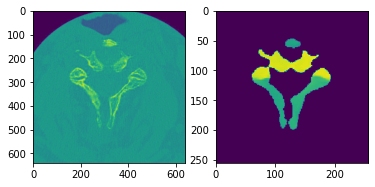

In [30]:
img, mask = ds[100]
_, axs = plt.subplots(1, 2)
axs[0].imshow(img[0, :, :])
axs[1].imshow(mask[0, :, :])

plt.show()

In [11]:
# batch_size = 32
# dl = DataLoader(ds, batch_size=batch_size, shuffle=False, num_workers=min(os.cpu_count(), batch_size))

In [12]:
def pred_det(model, x):
    pred = model(x)[0]
    max_indices = torch.argmax(pred[:, :, 4], dim=1)
    max_values = pred[torch.arange(x.shape[0]), max_indices, :] # N x 6
    
    bboxes, scores = max_values[:, :4], max_values[:, 4]
    bboxes[:, 2] += bboxes[:, 0]
    bboxes[:, 3] += bboxes[:, 1]
    return bboxes, scores
                
def get_bbox_class_list(seg_list, seg_bboxes):
    class_list = []
    for i in range(seg_list.shape[0]):
        class_index = get_bbox_class(seg_list[i, :, :], seg_bboxes[i, :])
        class_list.append(class_index)
        
    return torch.stack(class_list)     


def get_bbox_class(seg, bbox):
    """
    label 은 0.125 의 단위로, 
    seg: H x W
    bbox: [xmin, ymin, xmax, ymax]
    """
    xmin, ymin, xmax, ymax = bbox.int()
    area = seg[ymin:ymax, xmin:xmax]
    
    # print(area)
    result = torch.mean(area[area>0])
    result = torch.round(result / 0.125)
    
    return result

def get_class_score(scores, class_list, eps=1e-2):
    result = scores.new_zeros((scores.shape[0], 8)) + eps
    class_list = torch.nan_to_num(class_list).long()
    result[torch.arange(scores.shape[0]), class_list] = scores
    
    return result


def cal_loss(prob, label):
    
    pos_weight = np.array([14, 2, 2, 2, 2, 2, 2, 2])
    neg_weight = np.array([7, 1, 1, 1, 1, 1, 1, 1])
    
    score = pos_weight * label * np.log(prob) + neg_weight * (1 - label) * np.log(1 - prob)
    
    weight_total = pos_weight * label + neg_weight * (1 - label)
    
    return -score.sum(axis=1) / weight_total.sum(axis=1)


In [32]:
def get_test_df(UIDs):
    """
    UIDs : 1.2.826.0.1.3680043.219*
    """
    test_slices = glob.glob(f'{IMAGES_DIR}/{UIDs}/*')
    test_slices = [re.findall(f'{IMAGES_DIR}/(.*)/(.*).jpeg', s)[0] for s in test_slices]

    df_test_slices = pd.DataFrame(data=test_slices, columns=['StudyInstanceUID', 'Slice'])
    df_test_slices['UID_Slice'] = df_test_slices['StudyInstanceUID'] + '.' + df_test_slices['Slice'].astype('string')
    # df_test_slices = df_test_slices.set_index('UID_Slice').astype({'Slice': int})
    df = total_boundary_df.loc[df_test_slices.UID_Slice].sort_values(['StudyInstanceUID','Slice']).reset_index()

    return df

def get_loader(df, batch_size=32):
    tf = ImageTransform(image_size=640)
    ds = ImageDataSet(df, IMAGES_DIR, MASK_DIR, tf)
    
    dl = DataLoader(ds, batch_size=batch_size, shuffle=False, pin_memory=False, num_workers=min(16, batch_size))
    return dl

In [98]:
weights = "/root/cervical_spine/third/yolov7_custom/runs/train/yolov7-custom18/weights/last.pt"
model = attempt_load(weights, map_location=device)
model = model.eval()

Fusing layers... 
IDetect.fuse


In [99]:
def predict(dl, batch_size=32):
    
    with torch.no_grad():
        
        predictions = []
        
        for x, mask in tqdm(dl):
            x = x.to(device)
            mask = mask.to(device)
            
            batch_probs = x.new_zeros((x.shape[0], 8)) + 1e-2
            
            active_indices = mask.sum(axis=[1, 2, 3]).nonzero().reshape(-1)
            
            if active_indices.numel() == 0:
                predictions.append(batch_probs)
                continue
                
                
            # infer_result = torch.zeros((x.shape[0], 9))    
            if active_indices.numel() != batch_size:
                x = x[active_indices, :, :, :]
                mask = mask[active_indices, :, :, :]
            
            bboxes, scores = pred_det(model, x)
            
            class_list = get_bbox_class_list(mask[:, 0, :, :], bboxes / (IMAGE_SIZE / 256.) )
            # print(bboxes)
            # print(class_list)
            probs = get_class_score(scores, class_list)
            
            batch_probs[active_indices, :] = probs
#             print(probs)
            predictions.append(batch_probs)
    
        return torch.concat(predictions).cpu().numpy()
    
    
df = get_test_df('1.2.826.0.1.3680043.227*')
dl = get_loader(df)
predictions = predict(dl)

print("max score slice : ", np.argmax(predictions.max(axis=1), axis=0))

100%|██████████| 87/87 [00:33<00:00,  2.62it/s]

max score slice :  1966


In [100]:
# tf = ImageTransform(image_size=640)
# ds = ImageDataSet(df, IMAGES_DIR, MASK_DIR, tf)
# ds[0]

In [101]:
df_effnet_pred = pd.DataFrame(
    data=predictions, columns=['patient_overall'] + [f'C{i}' for i in range(1, 8)]
)
df_test_pred = pd.concat([df, df_effnet_pred], axis=1).sort_values(['StudyInstanceUID', 'Slice'])
df_patient_pred = df_test_pred.groupby('StudyInstanceUID').apply(lambda df: df.max())

clip_value = 1e-3
df_patient_pred[[f'C{i}' for i in range(1, 8)]] = df_patient_pred[[f'C{i}' for i in range(1, 8)]].clip(lower=clip_value, upper=1-clip_value)


df_patient_pred["patient_overall"] = df_patient_pred[[f'C{i}' for i in range(1, 8)]].max(axis=1)
df_patient_pred = df_patient_pred[['patient_overall'] + [f'C{i}' for i in range(1, 8)]]
df_patient_pred

,patient_overall,C1,C2,C3,C4,C5,C6,C7
StudyInstanceUID,,,,,,,,
1.2.826.0.1.3680043.22701,0.572066,0.166692,0.292008,0.208583,0.197764,0.139862,0.572066,0.403003
1.2.826.0.1.3680043.22711,0.604718,0.428224,0.243721,0.576641,0.604718,0.444174,0.446409,0.417418
1.2.826.0.1.3680043.22717,0.450650,0.239576,0.316498,0.254727,0.115812,0.450650,0.219306,0.140221
1.2.826.0.1.3680043.22755,0.297360,0.212856,0.107806,0.297360,0.179423,0.193941,0.288472,0.132885
1.2.826.0.1.3680043.22757,0.260895,0.078021,0.154223,0.049834,0.038260,0.044528,0.099639,0.260895
1.2.826.0.1.3680043.22759,0.771751,0.330919,0.402717,0.445295,0.771751,0.462875,0.534864,0.177175
1.2.826.0.1.3680043.22780,0.428039,0.255969,0.152622,0.319465,0.068093,0.187792,0.126508,0.428039
1.2.826.0.1.3680043.22793,0.736808,0.132438,0.736808,0.157349,0.270640,0.095197,0.148953,0.535649


In [102]:
prob = df_patient_pred.values
label = train_df.loc[df_patient_pred.index].values

# print(prob.shape)
# print(label.shape)

losses = cal_loss(prob, label)
print(list(losses))
print(losses)
print(np.mean(losses))
list(losses)

[0.5651311352849007, 0.7744319822107043, 0.44730759944234577, 0.2909262478351593, 0.2077064716390201, 0.35996280921002227, 0.8189669206090595, 0.2974615865810351]
[    0.56513     0.77443     0.44731     0.29093     0.20771     0.35996     0.81897     0.29746]
0.4702368441015309


[0.5651311352849007,
 0.7744319822107043,
 0.44730759944234577,
 0.2909262478351593,
 0.2077064716390201,
 0.35996280921002227,
 0.8189669206090595,
 0.2974615865810351]